## <b>Heuristic Comparison for A*</b> 

<p style="font-size:16px;">
Heuristic Comparison for A*<br>
Evaluating heuristic functions in the A* pathfinding algorithm.<br>
Average Total Cost, Nodes Explored, and Computation Time over 10 random 20×20 grids (Start=(0,0), Goal=(19,19)).
</p>


In [23]:
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


In [24]:
FLAT, SANDY, ROCK, CLIFF, TRAP, HAZARDOUS = "flat", "sandy", "rock", "cliff", "trap", "hazardous"

TERRAIN_COST = {
    FLAT: 5.0,
    SANDY: 10.0,
    ROCK: 1e6,       
    CLIFF: 1e6,       
    TRAP: 15.0,
    HAZARDOUS: 15.0
}

TERRAIN_LIST = [FLAT, SANDY, ROCK, CLIFF, TRAP, HAZARDOUS]
TERRAIN_WEIGHTS = [0.4, 0.25, 0.1, 0.1, 0.075, 0.075]   


In [25]:
GRID_SIZE = 20  

def generate_random_grid():
    return [
        random.choices(TERRAIN_LIST, weights=TERRAIN_WEIGHTS, k=GRID_SIZE)
        for _ in range(GRID_SIZE)
    ]


Defined Heuristics 

In [26]:
def manhattan(a, b, grid=None):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def euclidean(a, b, grid=None):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def terrain_aggressive(a, b, grid):
    (r1,c1),(r2,c2)=a,b
    d = math.hypot(r1-r2,c1-c2)
    steps = max(int(math.ceil(d*2)),1)
    tot = 0; cnt = 0
    for t in range(steps+1):
        alpha=t/steps
        rr=int(round(r1*(1-alpha)+r2*alpha))
        cc=int(round(c1*(1-alpha)+c2*alpha))
        if 0<=rr<GRID_SIZE and 0<=cc<GRID_SIZE:
            tot += min(TERRAIN_COST[grid[rr][cc]], 1000)
            cnt+=1
    return d * (tot/cnt if cnt else TERRAIN_COST[FLAT])

def adaptive_cost_manhattan(current, goal, grid=None):
    return 5.0 * (abs(current[0]-goal[0]) + abs(current[1]-goal[1]))

def obstacle_aversion(current, goal, grid):
    base = adaptive_cost_manhattan(current, goal)
    r, c = current

    best = float("inf")
    for rr in range(GRID_SIZE):
        for cc in range(GRID_SIZE):
            if grid[rr][cc] in [ROCK, CLIFF]:
                d = (r-rr)**2 + (c-cc)**2
                best = min(best, d)

    if best == float("inf"):
        return base

    best = max(best, 0.25)
    penalty = 10 * (1/best)
    return base + penalty

HEURISTICS = {
    "Manhattan": manhattan,
    "Euclidean": euclidean,
    "Terrain Aggressive": terrain_aggressive,
    "Adaptive H1": adaptive_cost_manhattan,
    "Obstacle Aversion H2": obstacle_aversion
}


Astar Function

In [27]:
import heapq

def in_bounds(n):
    r, c = n
    return 0 <= r < GRID_SIZE and 0 <= c < GRID_SIZE

def neighbors_4(n):
    r, c = n
    return [(r-1,c),(r+1,c),(r,c-1),(r,c+1)]

def astar(grid, start, goal, hfn):
    open_heap=[]
    heapq.heappush(open_heap,(0,0,start))
    g={start:0}
    came={}
    explored=0

    while open_heap:
        _, gc, cur = heapq.heappop(open_heap)
        explored+=1

        if cur == goal:
            # reconstruct
            path=[cur]
            while path[-1] in came:
                path.append(came[path[-1]])
            return path[::-1], explored, g[cur]

        for nb in neighbors_4(cur):
            if not in_bounds(nb): 
                continue

            t_cost = TERRAIN_COST[grid[nb[0]][nb[1]]]
            if t_cost >= 1e6:
                continue  # impassable

            ng = gc + t_cost
            if ng < g.get(nb, float("inf")):
                g[nb]=ng
                came[nb]=cur
                f = ng + hfn(nb, goal, grid)
                heapq.heappush(open_heap,(f,ng,nb))

    return None, explored, float("inf")


<p style="font-size:16px;">
Run A* with all heuristics on random grids<br>
Start = (0,0), Goal = (19,19)<br>
</p>

In [28]:
def run_comparison(num_trials=5):
    records = []

    for trial in range(num_trials):
        grid = generate_random_grid()
        start, goal = (0,0), (GRID_SIZE-1, GRID_SIZE-1)

        for name, hfn in HEURISTICS.items():
            t0 = time.time()
            path, explored, cost = astar(grid, start, goal, hfn)
            t1 = time.time()

            records.append({
                'Trial': trial + 1,
                'Heuristic': name,
                'Path Length': len(path) if path else None,
                'Total Cost': cost if path else float('inf'),
                'Nodes Explored': explored,
                'Time (s)': round(t1 - t0, 5)
            })

    return pd.DataFrame(records)



<p style="font-size:16px;">
Execute experiments on 10 random grids<br>
</p>

In [29]:
df = run_comparison(num_trials=10)
display(df)


,Trial,Heuristic,Path Length,Total Cost,Nodes Explored,Time (s)
0,1,Manhattan,NaN,inf,323,0.00152
1,1,Euclidean,NaN,inf,323,0.00101
2,1,Terrain Aggressive,NaN,inf,2618,0.06748
3,1,Adaptive H1,NaN,inf,344,0.00151
4,1,Obstacle Aversion H2,NaN,inf,364,0.01759
5,2,Manhattan,39.0,225.0,328,0.00050
6,2,Euclidean,39.0,225.0,328,0.00050
7,2,Terrain Aggressive,39.0,250.0,166,0.01154
8,2,Adaptive H1,39.0,225.0,187,0.00000
9,2,Obstacle Aversion H2,39.0,225.0,215,0.04445


<p style="font-size:16px;">
Compute average metrics per heuristic<br>
</p>

In [30]:
df_success = df[df["Total Cost"] != float("inf")]

summary_success = (
    df_success.groupby("Heuristic", as_index=False)
    .agg({
        "Total Cost": "mean",
        "Nodes Explored": "mean",
        "Time (s)": "mean"
    })
)

display(Markdown("Average Results — Successful Trials Only"))
display(summary_success)


Average Results — Successful Trials Only

,Heuristic,Total Cost,Nodes Explored,Time (s)
0,Adaptive H1,249.166667,237.666667,0.000385
1,Euclidean,249.166667,312.666667,0.000507
2,Manhattan,249.166667,312.666667,0.001017
3,Obstacle Aversion H2,249.166667,248.500000,0.021652
4,Terrain Aggressive,282.500000,104.666667,0.004608


<p style="font-size:16px;">
Average Total Cost<br>
</p>

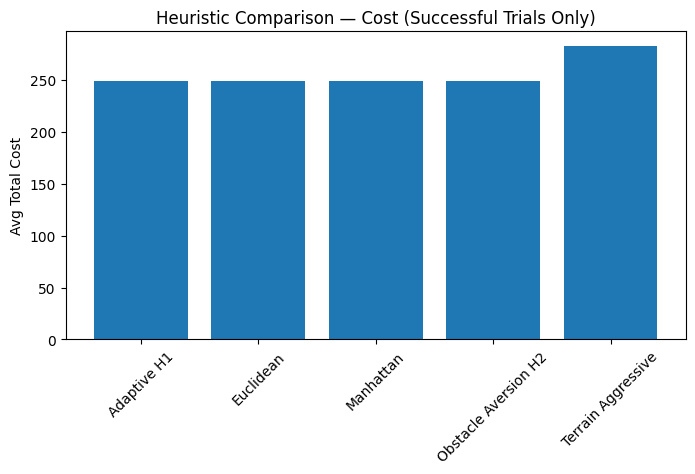

In [31]:
plt.figure(figsize=(8,4))
plt.bar(summary_success["Heuristic"], summary_success["Total Cost"])
plt.xticks(rotation=45)
plt.ylabel("Avg Total Cost")
plt.title("Heuristic Comparison — Cost (Successful Trials Only)")
plt.show()


<p style="font-size:16px;">
Average Nodes Explored<br>
</p>

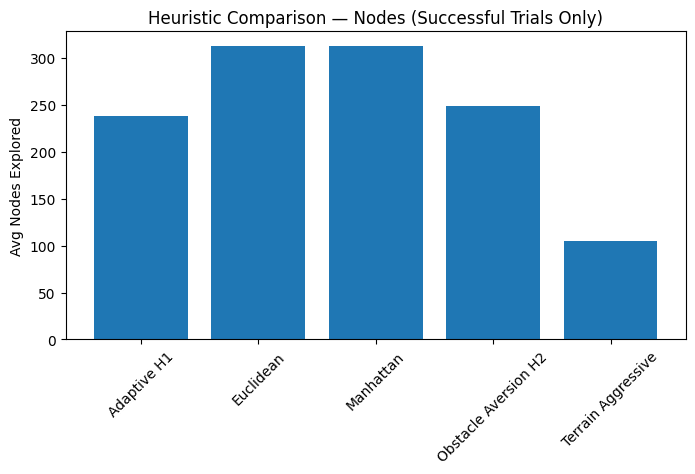

In [32]:
plt.figure(figsize=(8,4))
plt.bar(summary_success["Heuristic"], summary_success["Nodes Explored"])
plt.xticks(rotation=45)
plt.ylabel("Avg Nodes Explored")
plt.title("Heuristic Comparison — Nodes (Successful Trials Only)")
plt.show()


<p style="font-size:16px;">
Average Computation Time<br>
</p>

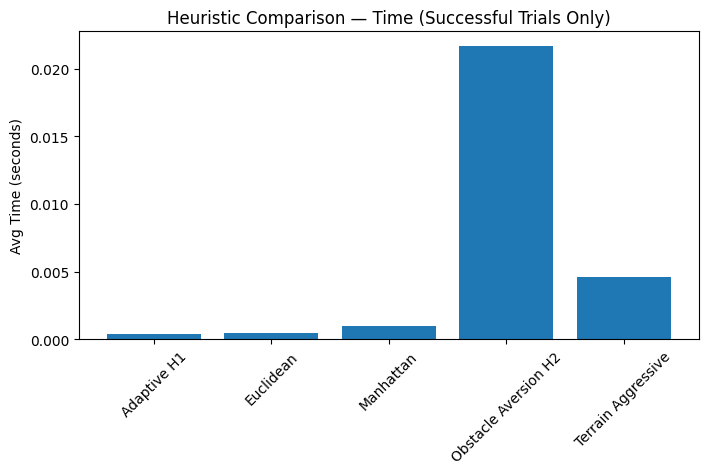

In [33]:
plt.figure(figsize=(8,4))
plt.bar(summary_success["Heuristic"], summary_success["Time (s)"])
plt.xticks(rotation=45)
plt.ylabel("Avg Time (seconds)")
plt.title("Heuristic Comparison — Time (Successful Trials Only)")
plt.show()


## Comparison Report

### Heuristic Comparison Summary

| Heuristic              | Efficiency (Nodes)  | Optimality (Cost)         | Speed (Computation Time) | Consistent | Admissible |
|-------------------------|--------------------|----------------------------|---------------------------|-------------|-------------|
| **Adaptive Cost (H1)**  | Moderate    | Moderate                  | Fast                      | Yes         | Yes         |
| **Euclidean**           | Low (many nodes)   | Moderate           | Fast                  | Yes         | Yes         |
| **Manhattan**           | Low (many nodes)   | Moderate           | Fast                 | Yes         | Yes         |
| **Obstacle Aversion (H2)** | Moderate  | Moderate            | Very Slow                      | No          | No          |
| **Terrain (Aggressive)** | High (fewer)  | Lowest (least optimal)     | Slow                 | No          | No          |

---

**Interpretation Summary**
- **Adaptive Cost (H1)** → Best overall balance: fast, efficient, and near-optimal with reliable consistency. 
- **Euclidean / Manhattan** → Most optimal but explore more nodes (less efficient).  
- **Obstacle Aversion (H2)** → Safe but very slow and not optimal due to inconsistency.
- **Terrain (Aggressive)** → Very efficient but produces the least optimal paths; slow and unreliable.
